In [5]:
#Importing Libraries
import pandas as pd 
from openpyxl import load_workbook
from openpyxl.utils import get_column_interval
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta
import os
import re
import math

In [6]:
#Constants and variables
    #Path
path = str(os.path.abspath("Forecast_Model_Markdown.ipynb")).replace("Forecast_Model_Markdown.ipynb","")

    # Weather Constants

temp_height = 10
wind_height = 10

    #Number of farms 
i = len(next(os.walk(path + "Input_Data/Farm_Data")))
Farms = ["F"+str(x) for x in range(1,i+1)]

    #Months list
Month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


    #My Variables
my_var = {}

Metrics = {} 

In [7]:
#Functions

    #Call specific range in an Excel sheet
def load_workbook_range(range_string, ws):
    col_start, col_end = re.findall("[A-Z]+", range_string)

    data_rows = []
    for row in ws[range_string]:
        data_rows.append([cell.value for cell in row])

    return pd.DataFrame(data_rows, columns=get_column_interval(col_start, col_end))

In [8]:
#Generating Market Dataframe    
       #Read and filter market data from Germany
df = pd.read_csv(path + "Input_Data/Market_Data/Market_data_prices.csv")
df = df[["Datum","Deutschland/Luxemburg[€/MWh]"]]
df["Datum"]= pd.to_datetime(df["Datum"],infer_datetime_format=True).astype('datetime64[ns]')

       #Create 15 min time resolution intervals with corresponding date 

start_d = (str(df["Datum"].iloc[0]).replace("-","/"))[0:10]
end_d = str(df["Datum"].iloc[-1] + timedelta(days=1)).replace("-","/")[0:10]

Time_date = (pd.DataFrame(columns=["NULL"],
                  index=pd.date_range(start= start_d , end = end_d,
                                      freq="15T"))
       .between_time("00:00","23:45")
       .index.strftime("%d.%m.%YT%H:%M")
       .tolist()
)
Time_date = Time_date[0:-1]

       #Prepare Table with 15 min intervals 
Germany_market = pd.DataFrame(np.repeat(df.values,4, axis= 0))
Germany_market.columns = df.columns
Germany_market["Datum"] = Time_date
Germany_market["Rebap [€]"] =pd.read_csv(path + "Input_Data/Market_Data/Rebap_prices.csv")["Rebap"]

Germany_market.head()

,Datum,Deutschland/Luxemburg[€/MWh],Rebap [€]
0,01.01.2020T00:00,41.88,-22.37
1,01.01.2020T00:15,41.88,77.75
2,01.01.2020T00:30,41.88,63.24
3,01.01.2020T00:45,41.88,44.12
4,01.01.2020T01:00,38.6,79.57


In [9]:
#Dictionaries
    #Read farm specific turbine data from excel and turn it into dictionary
for x in range(1,i+1):
    wb = load_workbook(filename=path + "Input_Data/Farm_Data/Weather_P"+ str(x)+"_F1.xlsx", read_only= True)
    ws = wb.active
    my_var["Turbine_values_"+str(x)] = load_workbook_range("G14:H21", ws)
    my_var["Turbine_specs_"+str(x)] = my_var["Turbine_values_"+str(x)].set_index("G").T.to_dict("list")
    #Read farm specific general data from excel and turn it into dictionary
    my_var["info_"+str(x)] = load_workbook_range("G2:H8", ws)
    my_var["General_information_"+str(x)] = my_var["info_"+str(x)] .set_index("G").T.to_dict("list")

print(" Example of general information dictionary for farm 1:\n" + str(my_var["General_information_1"]))

 Example of general information dictionary for farm 1:
{'Name': ['WP_Offenhausen'], 'Area': ['Offenhausen '], 'Latitude(°)': [49.42705], 'Longitude (°)': [11.44], 'Ground Elevation (m)': [563], 'Farm_ID': ['F1'], 'Promoter_ID': ['P1']}


In [10]:
#Farm data frames

for x in range(1,i+1):
    #Read and call farm specific weather data : Temperature, Wind, Production
    my_var["weather_farm_"+str(x)] = pd.ExcelFile(path + "Input_Data/Farm_Data/Weather_P" + str(x) +"_F1.xlsx").parse("Weather")
    my_var["weather_farm_"+str(x)] = my_var["weather_farm_"+str(x)][["Temp (°K)","Wind_Speed (m/s)","Generation (MWh)"]] 
    #Concatanate with Germany market data
    my_var["Farm_df_"+str(x)] = pd.concat([Germany_market, my_var["weather_farm_"+str(x)]], axis=1)

    #Day Ahead Prices 
    my_var["Farm_df_"+str(x)]["Day Ahead Price [€]"]= my_var["Farm_df_"+str(x)]["Deutschland/Luxemburg[€/MWh]"].astype(float)
    
    #Temperature extrapolation
    my_var["Farm_df_"+str(x)]["Temperature extrapolation [°K]"] = my_var["Farm_df_"+str(x)]["Temp (°K)"] - 0.0065 * (my_var["Turbine_specs_"+str(x)]["Hub Height (m)"][0]+temp_height)
    
    #Wind extrapolation 
    my_var["Farm_df_"+str(x)]["Wind extrapolation [m/s]"] = my_var["Farm_df_"+str(x)]["Wind_Speed (m/s)"]* (my_var["Turbine_specs_"+str(x)]["Hub Height (m)"][0]/wind_height)**my_var["Turbine_specs_"+str(x)]["Fric Coeff"][0]
    
    #Calculate polynomial regression coefficient for farm_n ´s turbine
    wb = load_workbook(filename=path + "Input_Data/Farm_Data/Weather_P"+ str(x)+ "_F1.xlsx", read_only=True)
    ws = wb.active
    my_var["pc_values_"+str(x)]= load_workbook_range("J2:K27", ws)
    my_var["x_"+str(x)] = np.array(my_var["pc_values_"+str(x)]["J"])[1::].astype(float)
    my_var["y_"+str(x)] = np.array(my_var["pc_values_"+str(x)]["K"])[1::].astype(float)
    my_var["y_normalized_"+str(x)] =  [float(i)/max(my_var["y_"+str(x)]) for i in my_var["y_"+str(x)]]
    my_var["best_fit_"+str(x)] = np.polyfit(my_var["x_"+str(x)], my_var["y_normalized_"+str(x)], 6).astype(float)
    
    #Best Fit values 
    V = my_var["Farm_df_"+str(x)]["Wind extrapolation [m/s]"]
    Bf = my_var["best_fit_"+str(x)]
    my_var["Farm_df_"+str(x)]["Best Fit"] = abs(round(Bf[0]* V**6 + Bf[1]* V**5 + Bf[2]* V**4 + Bf[3]* V**3 + Bf[4]* V**2 + Bf[5]* V**1 + Bf[6]* V**0,2))
    
    #Normalized production
    conditions =[
        (V < my_var["Turbine_specs_"+str(x)]["Cut in Speed (m/s)"][0]),
        (V <= my_var["Turbine_specs_"+str(x)]["Rated Speed (m/s)"][0]) & (V >= my_var["Turbine_specs_"+str(x)]["Cut in Speed (m/s)"][0]),
        (V > my_var["Turbine_specs_"+str(x)]["Rated Speed (m/s)"][0]) & (V <= my_var["Turbine_specs_"+str(x)]["Cut Out Speed (m/s)"][0]),
        (V > my_var["Turbine_specs_"+str(x)]["Cut Out Speed (m/s)"][0])
    ]
    values = [0, my_var["Farm_df_"+str(x)]["Best Fit"], 1, 0]

    my_var["Farm_df_"+str(x)]["Normalized Forecast"] = np.select(conditions, values)

    #Corrected normalized Power Output
    my_var["Farm_df_"+str(x)]["Corrected Norm Forecast"] = 2.7** (-(my_var["General_information_"+str(x)]["Ground Elevation (m)"][0]- my_var["Turbine_specs_"+str(x)]["Hub Height (m)"][0])/8430)* my_var["Farm_df_"+str(x)]["Normalized Forecast"]*(288.15/my_var["Farm_df_"+str(x)]["Temperature extrapolation [°K]"])
    
    #Actual generation 
    my_var["Farm_df_"+str(x)]["Actual Forecast [MWh]"] = my_var["Farm_df_"+str(x)]["Corrected Norm Forecast"] * my_var["Turbine_specs_"+str(x)]["Intalled Capacity (MW)"][0]

    #Direction Farm 
    my_var["Farm_df_"+str(x)]["Direction Farm"] = np.where(my_var["Farm_df_"+str(x)]["Generation (MWh)"]>my_var["Farm_df_"+str(x)]["Actual Forecast [MWh]"],"UP","DOWN")
   
   #Direction System 
    my_var["Farm_df_"+str(x)]["Direction System"] = np.where(my_var["Farm_df_"+str(x)]["Rebap [€]"]>0,"UP","DOWN")
   
    #Forecast Error 
    my_var["Farm_df_"+str(x)]["Forecast Error [MWh]"] = my_var["Farm_df_"+str(x)]["Generation (MWh)"] - my_var["Farm_df_"+str(x)]["Actual Forecast [MWh]"]
    
    #Forecast Error Costs 
    my_var["Farm_df_"+str(x)]["Forecast Error Cost [€]"] = np.where(my_var["Farm_df_"+str(x)]["Direction System"]==my_var["Farm_df_"+str(x)]["Direction Farm"],0,(my_var["Farm_df_"+str(x)]["Forecast Error [MWh]"]*my_var["Farm_df_"+str(x)]["Rebap [€]"])/4)
    
    #Market Income 
    my_var["Farm_df_"+str(x)]["Market Income [€]"] = (my_var["Farm_df_"+str(x)]["Actual Forecast [MWh]"]* my_var["Farm_df_"+str(x)]["Day Ahead Price [€]"])/4
    
    #Clean Columns
    my_var["c"+str(x)] = my_var["Farm_df_"+str(x)].drop(my_var["Farm_df_"+str(x)].columns[[1,3,4,9,10,11]], axis = 1, inplace=True)
    my_var["c"+str(x)] = my_var["Farm_df_"+str(x)].rename(columns={'Generation (MWh)': 'Generation [MWh]'}, inplace=True)

#Save data frames as CSV files 
for x in range(1,i+1):
    my_var["Farm_df_"+str(x)].to_csv(path + "Output_Data/Farm" + str(x)+ ".csv")

my_var["Farm_df_1"]

,Datum,Rebap [€],Generation [MWh],Day Ahead Price [€],Temperature extrapolation [°K],Wind extrapolation [m/s],Actual Forecast [MWh],Direction Farm,Direction System,Forecast Error [MWh],Forecast Error Cost [€],Market Income [€]
0,01.01.2020T00:00,-22.37,0.000000,41.88,272.0285,1.911942,0.000000,DOWN,DOWN,0.000000,0.000000,0.000000
1,01.01.2020T00:15,77.75,0.000000,41.88,272.0285,1.911942,0.000000,DOWN,UP,0.000000,0.000000,0.000000
2,01.01.2020T00:30,63.24,0.000000,41.88,272.0285,1.911942,0.000000,DOWN,UP,0.000000,0.000000,0.000000
3,01.01.2020T00:45,44.12,0.000000,41.88,272.0285,1.911942,0.000000,DOWN,UP,0.000000,0.000000,0.000000
4,01.01.2020T01:00,79.57,0.032096,38.60,271.6875,2.036065,0.000000,UP,UP,0.032096,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
35131,31.12.2020T22:45,116.98,0.937989,51.86,271.0605,4.973609,0.986510,DOWN,UP,-0.048521,-1.419006,12.790100
35132,31.12.2020T23:00,38.71,0.644127,52.26,271.0925,4.632681,0.616496,UP,UP,0.027631,0.000000,8.054518
35133,31.12.2020T23:15,84.82,0.633499,52.26,271.0925,4.632681,0.616496,UP,UP,0.017003,0.000000,8.054518
35134,31.12.2020T23:30,64.90,0.627507,52.26,271.0925,4.632681,0.616496,UP,UP,0.011011,0.000000,8.054518


In [11]:
#Calculation of forecasting evaluation metrics 

for x in range(1,i+1):
    n = len(my_var["Farm_df_"+str(x)])
    error = my_var["Farm_df_"+str(x)]["Forecast Error [MWh]"]

    #MAE(MWh)
    Metrics["MAE_"+str(x)]= (error.sum()/n)

    #nMAE(%)
    Metrics["nMAE_"+str(x)] = ((1/n)* (abs(error/my_var["Turbine_specs_"+str(x)]['Intalled Capacity (MW)']).sum()))*100
    
    #nRMSE(%)
    Metrics["nRMSE_"+str(x)] = (math.sqrt((((abs(error/my_var["Turbine_specs_"+str(x)]['Intalled Capacity (MW)']))**2)/n).sum()))*100
    
    #Percentual deviation (%)
    Metrics["Perc_dev_"+str(x)] = ((my_var["Farm_df_"+str(x)]["Actual Forecast [MWh]"].sum()/my_var["Farm_df_"+str(x)]["Generation [MWh]"].sum())-1)*100

    #Monthly Forecast values
    Metrics["Monthly_Error_"+str(x)] = my_var["Farm_df_"+str(x)].groupby(my_var["Farm_df_"+str(x)]['Datum'].astype('datetime64[ns]').dt.strftime('%B'))['Forecast Error [MWh]'].sum().sort_values()
    Metrics["Monthly_Error_"+str(x)] = Metrics["Monthly_Error_"+str(x)].reindex(Month_order, axis=0)

    #Monthly Forecast Error Costs values
    Metrics["Monthly_Error_Cost_"+str(x)] = my_var["Farm_df_"+str(x)].groupby(my_var["Farm_df_"+str(x)]['Datum'].astype('datetime64[ns]').dt.strftime('%B'))["Forecast Error Cost [€]"].sum().sort_values()
    Metrics["Monthly_Error_Cost_"+str(x)] = Metrics["Monthly_Error_Cost_"+str(x)].reindex(Month_order, axis=0)

    #Monthly Day-ahead income 
    Metrics["Monthly_Income_"+str(x)] = my_var["Farm_df_"+str(x)].groupby(my_var["Farm_df_"+str(x)]['Datum'].astype('datetime64[ns]').dt.strftime('%B'))["Market Income [€]"].sum().sort_values()
    Metrics["Monthly_Income_"+str(x)] = Metrics["Monthly_Income_"+str(x)].reindex(Month_order, axis=0)
    
    #Monthly Generation
    Metrics["Monthly_Generation_"+str(x)] = my_var["Farm_df_"+str(x)].groupby(my_var["Farm_df_"+str(x)]['Datum'].astype('datetime64[ns]').dt.strftime('%B'))['Generation [MWh]'].sum().sort_values()
    Metrics["Monthly_Generation_"+str(x)] = Metrics["Monthly_Generation_"+str(x)].reindex(Month_order, axis=0)

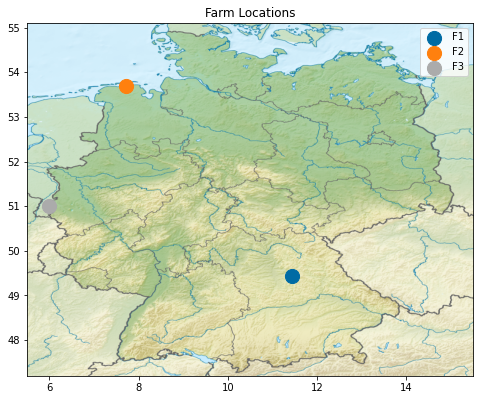

In [12]:
#Locations
Longitude =  [my_var["General_information_" + str(x)]['Longitude (°)'][0]for x in range(1,i+1)]
Latitude = [my_var["General_information_" + str(x)]['Latitude(°)'][0]for x in range(1,i+1)]
plt.style.use("tableau-colorblind10")
BBox = (5.5,15.5, 47.2,55.1)
map_ger = plt.imread(path + '/Map_Germany.png')
fig, ax = plt.subplots(figsize = (8,7))
for x in range(1,i+1):
    plt.scatter(Longitude[x-1],Latitude[x-1], label = Farms[x-1], s=200)
plt.legend(Farms)
plt.title('Farm Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(map_ger, zorder=0, extent = BBox, aspect= 'equal')
plt.show()

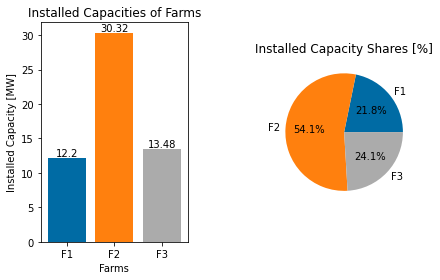

In [13]:
#Installed capacities
    #Installed capacities whole
inst= [my_var["Turbine_specs_"+str(x)]['Intalled Capacity (MW)'][0]for x in range(1,i+1)]
plt.style.use("tableau-colorblind10")
plt.subplot(1,2,1,)
for x in range(1,i+1):
    plt.bar(Farms[x-1],inst[x-1])
plt.title("Installed Capacities of Farms")
plt.xlabel("Farms")
plt.ylabel("Installed Capacity [MW]")
for x in range(1,i+1):
    plt.text(x-1,inst[x-1],str(round(inst[x-1],2)),ha= "center",va="bottom")

    #Capacity Shares
plt.subplot(1,2,2)
plt.pie(inst, labels= Farms,autopct= '%.1f%%')
plt.title("Installed Capacity Shares [%]")
plt.tight_layout(w_pad=8)
plt.show()

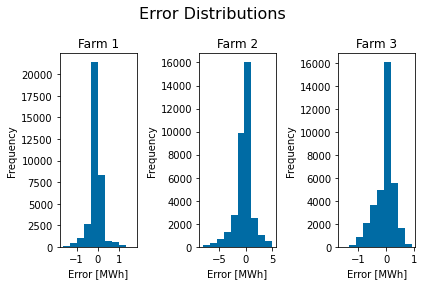

In [14]:
#Error Distribution
plt.style.use("tableau-colorblind10")
fig, axes = plt.subplots(1, i)
fig.suptitle('Error Distributions', fontsize=16)
for x in range(1,i+1):
    plt.subplot(1,3,x)
    plt.title('F'+str(x))
    plt.hist(my_var["Farm_df_"+str(x)]["Forecast Error [MWh]"])
    plt.xlabel("Error [MWh]")
    plt.ylabel("Frequency")
    plt.title("Farm " + str(x))
    plt.tight_layout(w_pad=1, h_pad=1)
plt.show()


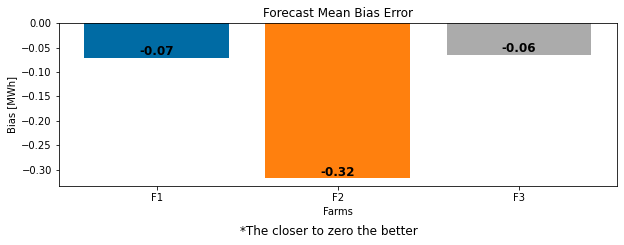

In [15]:
#Mean bias error
plt.style.use("tableau-colorblind10")
plt.figure(figsize=(10,3))
txt="*The closer to zero the better"
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=12)
for x in range(1,i+1):
    plt.bar(Farms[x-1], [Metrics["MAE_"+str(x)]])
plt.title('Forecast Mean Bias Error')
plt.xlabel("Farms")
plt.ylabel("Bias [MWh]")
for x in range(1,i+1):
    plt.text(x-1,Metrics["MAE_"+str(x)],str(round(Metrics["MAE_"+str(x)],2)),ha= "center",va="bottom", size = 12, weight="bold")
plt.show()

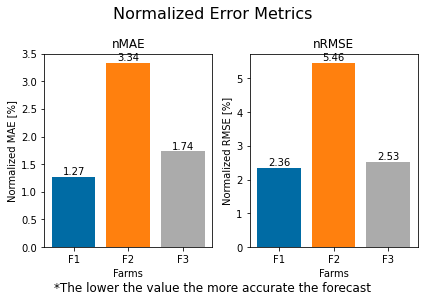

In [16]:
#Normalized Metrics
plt.style.use("tableau-colorblind10")
fig, axes = plt.subplots(1, 2)
txt="*The lower the value the more accurate the forecast"
plt.figtext(0.5, -0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
fig.suptitle('Normalized Error Metrics', fontsize=16)

    #nMAE(%)
plt.subplot(1,2,1)
for x in range(1,i+1):
    plt.bar(Farms[x-1], Metrics["nMAE_"+str(x)])
plt.title('nMAE')
plt.xlabel("Farms")
plt.ylabel("Normalized MAE [%]")
plt.tight_layout(w_pad=1, h_pad=1)
for x in range(1,i+1):
    plt.text(x-1,Metrics["nMAE_"+str(x)],str(round(Metrics["nMAE_"+str(x)],2)),ha= "center",va="bottom")

    #nRMSE(%)
plt.subplot(1,2,2)
for x in range(1,i+1):
    plt.bar(Farms[x-1], Metrics["nRMSE_"+str(x)])
plt.title('nRMSE')
plt.xlabel("Farms")
plt.ylabel("Normalized RMSE [%]")
plt.tight_layout(w_pad=1, h_pad=1)
for x in range(1,i+1):
    plt.text(x-1,Metrics["nRMSE_"+str(x)],str(round(Metrics["nRMSE_"+str(x)],2)),ha= "center",va="bottom")
plt.show()

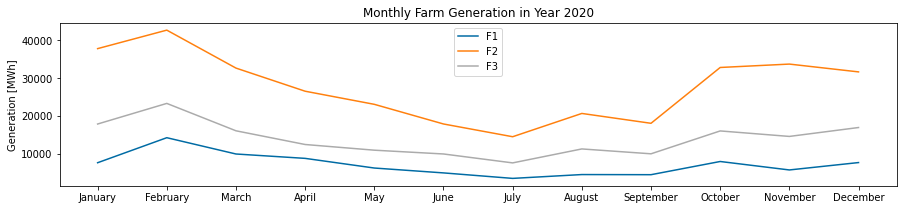

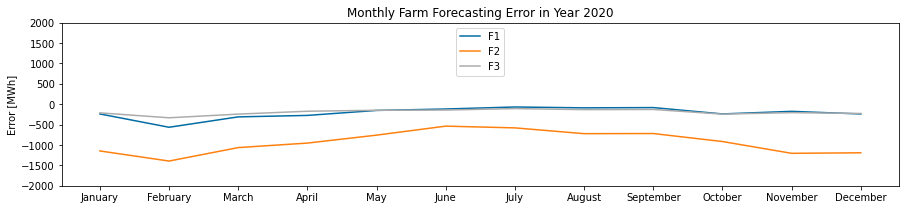

In [17]:
#Monthly Forecast error values
plt.style.use("tableau-colorblind10")
plt.figure(figsize=(15,3))
for x in range(1,i+1):
    plt.plot( Metrics["Monthly_Generation_"+str(x)], label= Farms[x-1])
    plt.title("Monthly Farm Generation in Year 2020")
    plt.legend(loc ="upper center")
    plt.ylabel("Generation [MWh]")
plt.show()

plt.figure(figsize=(15,3))
for x in range(1,i+1):
    plt.plot(Month_order, Metrics["Monthly_Error_"+ str(x)], label = str(Farms[x-1]))
    plt.title("Monthly Farm Forecasting Error in Year 2020")
    plt.legend(loc ="upper center")
    plt.ylabel("Error [MWh]")
    plt.ylim(-2000,2000)
plt.show()


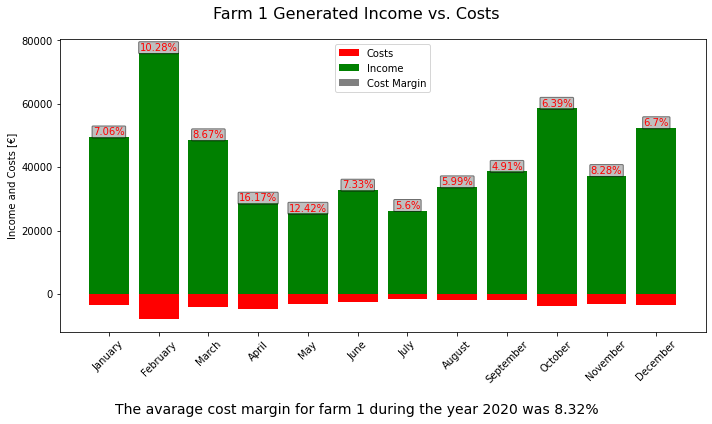

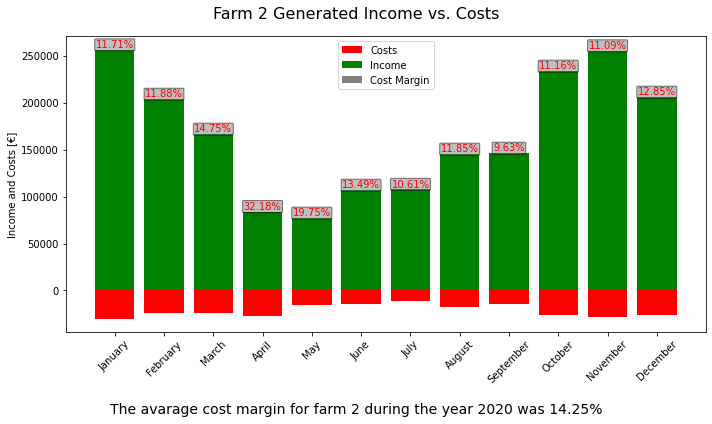

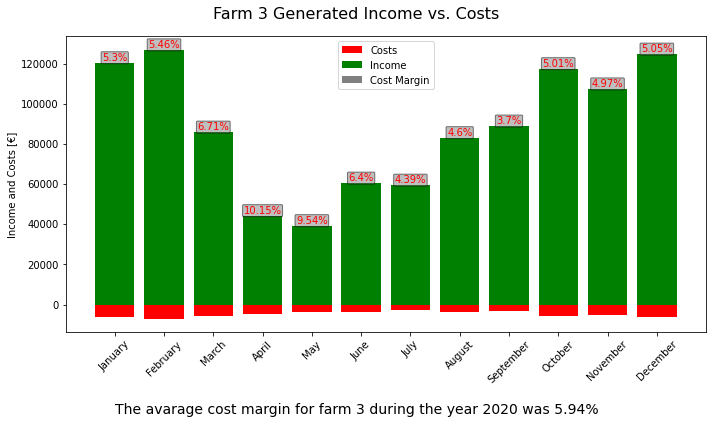

In [18]:
#Forecast Costs 

for x in range(1,i+1):
    plt.figure(figsize=(10, 5))
    plt.suptitle("Farm "+ str(x) + " Generated Income vs. Costs", fontsize=16)
    plt.bar(Month_order, Metrics["Monthly_Error_Cost_"+ str(x)], color = "red", label= "Costs")
    plt.bar(Month_order, Metrics["Monthly_Income_"+ str(x)],color = "green", label = "Income")
    plt.bar(0,0, color="Grey", label="Cost Margin")
    plt.tight_layout(w_pad=0.1, h_pad=1)
    plt.legend(loc ="upper center")
    plt.ylabel("Income and Costs [€]")
    plt.tight_layout(w_pad=1, h_pad = 1)
    plt.xticks(rotation=45)
    Y_cost_margin = round(abs((((Metrics["Monthly_Error_Cost_"+ str(x)]/Metrics["Monthly_Income_"+ str(x)]).sum())/12)*100),2)
    txt="The avarage cost margin for farm " +str(x) +" during the year 2020 was "+ str(Y_cost_margin) + "%"
    plt.figtext(0.5, -0.15, txt, wrap=True, horizontalalignment='center', fontsize=14)
    
    for m in range(0,12):
        Cost_margin= str(abs(round(((Metrics["Monthly_Error_Cost_"+ str(x)][m])/(Metrics["Monthly_Income_"+ str(x)][m]))*100,2)))+"%"
        plt.text(m,Metrics["Monthly_Income_"+ str(x)][m],Cost_margin,ha= "center",va="bottom", color ="red",bbox=dict(boxstyle ="round", pad= 0.1,facecolor='grey', alpha=0.5)) 
plt.show()
